# Current TD Portfolio

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Fund Summary

In [1]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import os
import pandas as pd
path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\private_data'
from IPython.display import Markdown as md
from IPython.display import display, HTML
import xlrd
from yahoo_fin.stock_info import *
from yahoo_fin import stock_info as si

import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7
import altair as alt

import yahooquery
from yahooquery import Ticker

import locale
locale.setlocale( locale.LC_ALL, '' ) #this used to format currency


'English_United States.1252'

In [2]:
def get_stock_details(tickers, startdate, enddate):
    output = pd.DataFrame()
    for ticker in tickers:
        tmp = si.get_data(ticker, start_date = startdate, end_date = enddate)
        output = output.append(tmp)
    output['date'] = output.index
    return output
def plot_pie_chart_dist(data, group_by_feature, dist_feature):
    # plot link: https://python-graph-gallery.com/161-custom-matplotlib-donut-plot/
    data_smr = pd.DataFrame(data.groupby(group_by_feature)[dist_feature].agg('sum').round(0))
    display(HTML(data_smr.to_html()))
    data_smr[group_by_feature] = data_smr.index

    my_circle=plt.Circle( (0,0), 0.5, color='white')
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
    plt.pie(data_smr[dist_feature], 
            labels=data_smr[group_by_feature], 
            colors=Pastel1_7.hex_colors, 
            autopct='%1.1f%%',
            wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(dist_feature + ' distribution by different ' + group_by_feature)
    plt.show()


def get_etf_holding(ticker):
    t = Ticker(ticker)
    print('===============================',ticker,'=================================')
    print()
    print('-------------------------- Key Factor ----------------------------')
    print(pd.DataFrame(t.key_stats[ticker], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
    print('-------------------------- Fund Sector ----------------------------')
    fund_sector = t.fund_sector_weightings
    if len(fund_sector) >1:
        fund_sector.insert(0,'Fund Sector',fund_sector.index)
        fund_sector = fund_sector.reset_index(drop=True)
        fund_sector.columns = ['Fund Sector','Percentage']
        fund_sector = fund_sector.sort_values(by='Percentage', ascending=False)
    print(fund_sector)
    print('-------------------------- Holdings ----------------------------')
    if type(t.fund_holding_info[ticker]) != str:
        print(pd.DataFrame(t.fund_holding_info[ticker]['holdings']))
    print('-------------------------- Returns ----------------------------')
    if type(t.fund_performance[ticker]) != str:
        print(pd.DataFrame(t.fund_performance[ticker]['performanceOverview'], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
        print()
        print(pd.DataFrame(t.fund_performance[ticker]['trailingReturns'], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
        print()
        print(pd.DataFrame(t.fund_performance[ticker]['annualTotalReturns']['returns']))
    print('-------------------------- Risk Factors ----------------------------')
    if type(t.fund_performance[ticker]) != str:
        print(pd.DataFrame(t.fund_performance[ticker]['riskOverviewStatistics']['riskStatistics']))
    print('=========================================================================')


In [3]:
# Load File
file = 'stock_smr.xlsx'
holding_tranc = 'holding_transaction'
cash_tranc = 'cash_transaction'

from datetime import datetime, timedelta
td = str((datetime.today() - timedelta(days = max(1, (datetime.today().weekday() + 6) % 7 - 3))).strftime('%m/%d/%Y'))
lstyear = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = -365)).strftime('%m/%d/%Y'))
lstqtr = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = -90)).strftime('%m/%d/%Y'))
tmr = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = 1)).strftime('%m/%d/%Y'))

initial_fund = pd.read_excel(os.path.join(path,file), sheet_name = cash_tranc)
stock_tranc = pd.read_excel(os.path.join(path,file), sheet_name = holding_tranc)
stock_tranc['total_amt'] = -1 * stock_tranc['amount_per_share'] * stock_tranc['share']

initial_fund

,date,currency,value
0,2020-01-01,CAD,41327.0
1,2020-01-01,USD,21347.0
2,2021-07-03,CAD,NaN


In [4]:
# Get Cash Value
initial_fund = initial_fund[initial_fund.date<datetime.strptime(td,'%m/%d/%Y')]
stock_tranc = stock_tranc[stock_tranc.date<datetime.strptime(td,'%m/%d/%Y')]

initial_fund_CAD = initial_fund[initial_fund.currency == 'CAD']['value'].sum()
initial_fund_USD = initial_fund[initial_fund.currency == 'USD']['value'].sum()
current_cash_CAD = initial_fund[initial_fund.currency == 'CAD']['value'].sum() + stock_tranc[stock_tranc.currency=='CAD']['total_amt'].agg('sum')
current_cash_USD = initial_fund[initial_fund.currency == 'USD']['value'].sum() + stock_tranc[stock_tranc.currency=='USD']['total_amt'].agg('sum')
current_cash ={
    'currency': ['CAD','USD'],
    'value': [current_cash_CAD, current_cash_USD]
}
current_cash = pd.DataFrame(current_cash)
curr_cadusd = pd.to_numeric(si.get_data('CADUSD=X', start_date = td, end_date = tmr).sort_index(ascending=False).head(1).adjclose)[0]


In [5]:
# Get Current Holdings
current_hold = stock_tranc.groupby('ticker')['share','total_amt'].agg('sum')
current_hold['cost'] = current_hold.total_amt / current_hold.share
current_hold = current_hold.reset_index()
current_hold = current_hold.merge(stock_tranc[['ticker', 'category', 'currency', 'products']], how = 'left', on = 'ticker')
current_hold

active_stock_ticker = current_hold.ticker.unique()
hold_stock_detail = get_stock_details(active_stock_ticker, lstqtr, td)

from pandasql import sqldf, load_meat, load_births
pysqldf = lambda q: sqldf(q, globals())

stock_curr_price = hold_stock_detail[hold_stock_detail.adjclose.notnull()].sort_values(by = ['date'], ascending=False).groupby('ticker').head(3)
stock_curr_price['rank'] = stock_curr_price.groupby('ticker')['date'].rank(method = 'first', ascending = False)
query = """
    SELECT 
        A.ticker
        , A.currency
        , A.share
        , A.cost as cost_per_share
        , C.adjclose as lastday_price
        , B.adjclose as today_price
        , A.total_amt as total_cost
        , round(case when A.ticker = 'CASH' then A.cost else B.adjclose * A.share end) as curr_value
        , round((B.adjclose + A.cost) * A.share) as profit
        , -1 * B.adjclose / A.cost - 1 as today_roe
        , B.adjclose / C.adjclose - 1 as today_ir
        , A.category
        , A.products
    FROM 
        current_hold A
    LEFT JOIN 
        stock_curr_price B on A.ticker = B.ticker and B.rank = 1
    LEFT JOIN 
        stock_curr_price C on A.ticker = C.ticker and C.rank = 2
        
    UNION
    
    SELECT 
        'CASH' as ticker
        , currency
        , '' as share
        , '' as cost_per_share
        , '' as lastday_price
        , '' as today_price
        , '' as total_cost
        , value as curr_value
        , '' as profit
        , '' as today_roe
        , '' as today_ir
        , 'CASH' as category
        , 'CASH' as products
    
    FROM current_cash
    """
stock_curr_smr = pysqldf(query)
stock_curr_smr.insert(11,'curr_value_in_cad', np.where(stock_curr_smr['currency'] == 'CAD', stock_curr_smr['curr_value'], stock_curr_smr['curr_value']/curr_cadusd))
display(stock_curr_smr)


,ticker,currency,share,cost_per_share,lastday_price,today_price,total_cost,curr_value,profit,today_roe,today_ir,curr_value_in_cad,category,products
0,0P00016N6T.TO,CAD,109.17,-36.64,37.34,36.73,-3999.99,4010.0000,10,0.00245632,-0.0163364,4010.000000,IT,MUTUAL
1,CASH,CAD,,,,,,26797.5112,,,,26797.511200,CASH,CASH
2,CASH,USD,,,,,,17207.4600,,,,21201.311268,CASH,CASH
3,ENB.TO,CAD,80,-36.12,49.4,49.63,-2889.6,3970.0000,1081,0.374031,0.00465586,3970.000000,OIL,STOCK
4,HGU.TO,CAD,75,-32.54,16.95,17.28,-2440.5,1296.0000,-1144,-0.468961,0.019469,1296.000000,GOLD,ETF
5,HUZ.TO,CAD,250,-12.37,12.56,12.71,-3092.5,3178.0000,85,0.0274859,0.0119426,3178.000000,SILVER,ETF
6,HZU.TO,CAD,90,-23.41,17.31,17.85,-2106.9,1607.0000,-500,-0.237505,0.0311959,1607.000000,SILVER,ETF
7,SPCE,USD,70,-16.94,46,43.19,-1185.8,3023.0000,1837,1.54959,-0.061087,3724.638265,SPACE,STOCK
8,VDE,USD,57,-51.82,75.89,77.26,-2953.74,4404.0000,1450,0.49093,0.0180525,5426.168349,OIL,ETF


## Holdings Summary
**Portfolio Summary {{ td }}**
* **Initial Fund**: *CAD*: {{ locale.currency(initial_fund_CAD, grouping=True) }}, *USD*: {{ locale.currency(initial_fund_USD, grouping=True)}}, *All in CAD*: {{ locale.currency(initial_fund_CAD + initial_fund_USD/curr_cadusd, grouping=True)}}.
* **Current Cash**: *CAD*: {{locale.currency(current_cash_CAD, grouping=True)}}, *USD*: {{locale.currency(current_cash_USD, grouping=True)}}, *All in CAD*: {{locale.currency(current_cash_CAD + current_cash_USD/curr_cadusd, grouping=True)}}
* **Investment Percentage**: *CAD*: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum()-current_cash_CAD)/stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum())}}, *USD*: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()-current_cash_USD)/stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum())}}, *Overall*: {{               "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd - current_cash_CAD - current_cash_USD/curr_cadusd) / (stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd))}}
* **Market Value**: *CAD*: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum(), grouping=True)}}, *USD*: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum(), grouping=True)}},  *All in CAD*: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() + stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum()/curr_cadusd, grouping=True) }}
* **Profit**: *CAD*: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD, grouping=True)}}, *USD*: {{locale.currency(stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD, grouping=True)}}, *All in CAD*: {{locale.currency((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD) + (stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD) /curr_cadusd , grouping=True)}}
* **ROE**: *CAD*: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD)/initial_fund_CAD) }}, *USD*: {{ "{:.1%}".format((stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD)/initial_fund_USD) }}, *Overall*: {{ "{:.1%}".format(((stock_curr_smr[stock_curr_smr.currency=='CAD']['curr_value'].sum() - initial_fund_CAD) + (stock_curr_smr[stock_curr_smr.currency=='USD']['curr_value'].sum() - initial_fund_USD) /curr_cadusd)/(initial_fund_CAD + initial_fund_USD/curr_cadusd)) }}

## Fund Distribution

,curr_value
products,
CASH,17207.0
ETF,4404.0
STOCK,3023.0


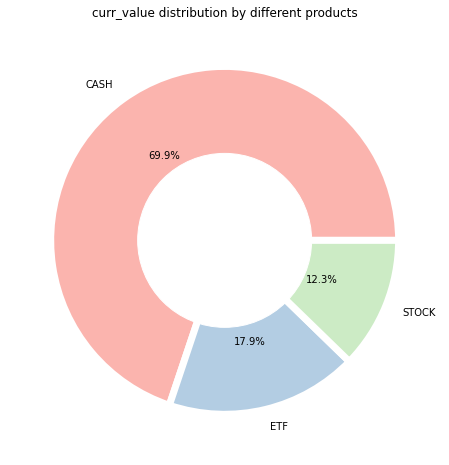

In [6]:
plot_pie_chart_dist(stock_curr_smr[stock_curr_smr.currency=='USD'], 'products', 'curr_value')

,curr_value
products,
CASH,26798.0
ETF,6081.0
MUTUAL,4010.0
STOCK,3970.0


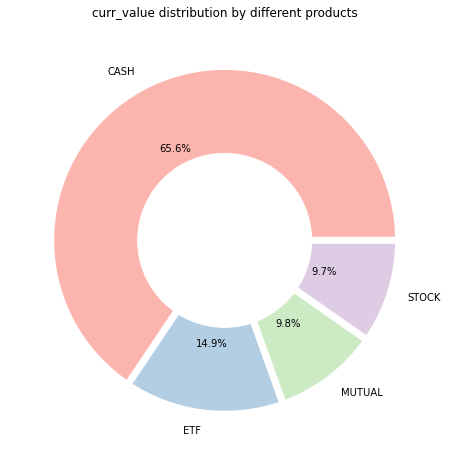

In [7]:
plot_pie_chart_dist(stock_curr_smr[stock_curr_smr.currency=='CAD'], 'products', 'curr_value')

,curr_value_in_cad
category,
CASH,47999.0
GOLD,1296.0
IT,4010.0
OIL,9396.0
SILVER,4785.0
SPACE,3725.0


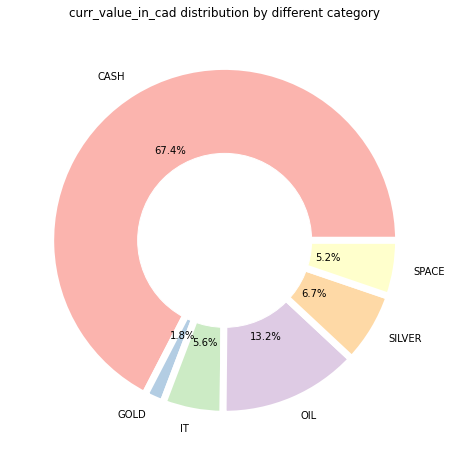

In [8]:
plot_pie_chart_dist(stock_curr_smr, 'category', 'curr_value_in_cad')

## Current Holdings Market Watch

In [9]:
alt.Chart(hold_stock_detail[hold_stock_detail.ticker!='SPCE']).mark_line().encode(x='date',y='volume', color = 'ticker:N')

alt.Chart(...)

## Watch List

In [10]:
watchlist = pd.read_excel(os.path.join(path,file), sheet_name = 'watchlist')
watchlist_df = get_stock_details(watchlist["ticker"].unique(), lstqtr, td)
watchlist_df.head(3)

,open,high,low,close,adjclose,volume,ticker,date
2021-04-05,27.520000,27.985001,27.500000,27.610001,27.610001,5155400,JETS,2021-04-05
2021-04-06,27.719999,28.049999,27.650999,27.840000,27.840000,4328100,JETS,2021-04-06
2021-04-07,27.920000,28.025000,27.459999,27.570000,27.570000,3561700,JETS,2021-04-07


In [11]:
alt.Chart(watchlist_df).mark_line().encode(x='date',y='volume', color = 'ticker:N')

alt.Chart(...)

In [12]:
watchlist["ticker"].unique()

array(['JETS', 'BKNG'], dtype=object)

In [13]:
get_etf_holding('JETS')

=============================== JETS =================================

-------------------------- Key Factor ----------------------------
                                        Value
maxAge                                      1
priceHint                                   2
category                 Miscellaneous Sector
ytdReturn                              0.0824
beta3Year                                1.82
totalAssets                        3974785024
yield                                       0
fundFamily              U.S. Global Investors
fundInceptionDate         2015-04-29 20:00:00
legalType                Exchange Traded Fund
threeYearAverageReturn                -0.0517
fiveYearAverageReturn                  0.0352
lastSplitFactor                          None
-------------------------- Fund Sector ----------------------------
               Fund Sector  Percentage
8              industrials       0.991
4               technology       0.009
0               realestate      

In [14]:
get_etf_holding('0P00016N6T.TO')

=============================== 0P00016N6T.TO =================================

-------------------------- Key Factor ----------------------------
                                        Value
maxAge                                      1
priceHint                                   2
morningStarOverallRating                    0
morningStarRiskRating                       0
category                                 None
annualReportExpenseRatio               0.0199
beta3Year                                1.24
totalAssets                        1851359872
fundFamily                               None
fundInceptionDate         2015-10-19 20:00:00
legalType                                None
lastSplitFactor                          None
annualHoldingsTurnover                 0.7489
-------------------------- Fund Sector ----------------------------
               Fund Sector  Percentage
4               technology      0.5880
5   communication_services      0.1770
1        consumer_cycli